In [2]:
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt 
from tensorflow.keras import optimizers
import numpy as np 
import math 
from PIL import Image
import tensorflow as tf 

c:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.

In [3]:
keras.mixed_precision.set_global_policy("mixed_float16")
model = keras_cv.models.StableDiffusion(jit_compile=True)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [4]:
prompt_1 = "Panda wearing a blue hat, dark fantasy art,"
prompt_2 = "Cat wearing a blue hat, dark fantasy art, " 

interpolation_steps = 5

encoding_1 = tf.squeeze(model.encode_text(prompt_1))
encoding_2 = tf.squeeze(model.encode_text(prompt_2))

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)

In [8]:
seed = 12345
noise = tf.random.normal((512//8, 512//8,4), seed=seed)

images = model.generate_image(
    interpolated_encodings,
    batch_size= interpolation_steps,
    diffusion_noise=noise
)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2543s 49s/step


In [9]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

In [10]:
export_as_gif(
    "panda-cat.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True,
)

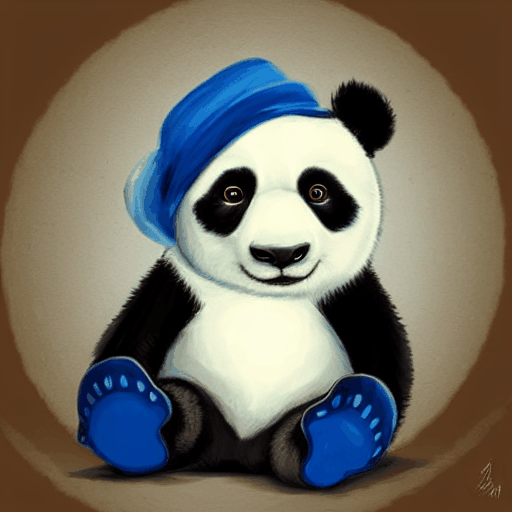

In [11]:
from IPython.display import Image as IImage
IImage("Panda-cat.gif")

In [14]:
intrpolation_steps = 150
batch_size = 3
batches= interpolation_steps // batch_size

interpolated_encodings = tf.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = tf.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images +=[
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise
        )
    ]

export_as_gif("panda-cat-fino.gif", images, rubber_band=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 688s 27s/step


In [5]:
prompt = "A majestic cat wearing an ornate golden hat, surrounded by floating orbs of light, in a dark illuminist painting, high detail, cinematic, "

seed = 42
tf.random.set_seed(seed)

encoding = tf.squeeze(model.encode_text(prompt))

walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size

noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=seed)

walk_noise_x = tf.random.normal(noise.shape, dtype='float64', seed=seed)
walk_noise_y = tf.random.normal(noise.shape, dtype='float64', seed=seed)

walk_scale_x = tf.cos(tf.linspace(0, 4, walk_steps)* math.pi)
walk_scale_y = tf.sin(tf.linspace(0, 4, walk_steps)* math.pi)

noise_x = tf.tensordot(walk_scale_x, walk_noise_x, axes=0)
noise_y = tf.tensordot(walk_scale_y, walk_noise_y, axes=0)
noise = tf.add(noise_x, noise_y)

batched_noise = tf.split(noise, batches)

images = []

for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            encoding,
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=batched_noise[batch]
        )
    ]

export_as_gif("cat_hat_variation.gif", images, rubber_band=True )

25/25 ━━━━━━━━━━━━━━━━━━━━ 771s 27s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 657s 26s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 633s 25s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 621s 25s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 624s 25s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 666s 27s/step
 3/25 ━━━━━━━━━━━━━━━━━━━━ 9:13 25s/step

KeyboardInterrupt: 